In [1]:
import numpy as np
import pandas as pd
import os
import glob
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Data Process

In [5]:
def load_raw(csv_file):
    df = pd.read_csv(csv_file, header=None)
    coords = df.apply(lambda row: np.array([[int(y) for y in x.strip('[]').split(', ')] for x in row[1:]]), axis=1)
    coords_list = coords.tolist()
    return coords_list


def calculate_jcd(coords):
    distances = squareform(pdist(coords, 'euclidean'))
    tril_indices = np.tril_indices_from(distances, k=-1)
    jcd_features = distances[tril_indices]
    return jcd_features


def raw_process(file_path):
    raw_data = []
    coords_list = load_raw(file_path)
    for coords in coords_list:
        jcd_features = calculate_jcd(np.array(coords))
        raw_data.append(jcd_features)
    raw_data_array = np.array(raw_data)
    raw_data_df = pd.DataFrame(raw_data_array)
    return raw_data_df


def save_jcd(raw_data_df, csv_file, save_dir):
    base_name = os.path.basename(csv_file)
    save_name = base_name.replace('keypoint', 'jcd')
    save_path = os.path.join(save_dir, save_name)
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    raw_data_df.to_csv(save_path, index=False, header=False)
    print(f"JCD features saved to {save_path}")


def process_jcd_files(data_dir, save_dir):
    csv_files = glob.glob(os.path.join(data_dir, '*.csv'))
    for csv_file in csv_files:
        raw_data_df = raw_process(csv_file)
        save_jcd(raw_data_df, csv_file, save_dir)

# raw_dir = '../data/raw'
# jcd_dir = '../data/jcd'
# process_jcd_files(raw_dir, jcd_dir)

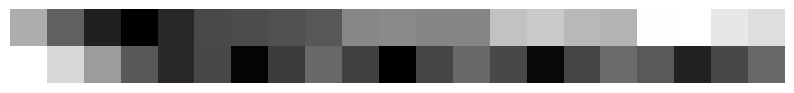

In [43]:
raw_0_path = '../data/raw/keypoint_1.csv'
coords_list = load_raw(raw_0_path)

row_1 = coords_list[0]

x_values = []
y_values = []

for point in row_1:
    point_str = str(point)
    numbers = point_str.strip('[]').split()
    x_values.append(int(numbers[0]))
    y_values.append(int(numbers[1]))

x_min, x_max = min(x_values), max(x_values)
y_min, y_max = min(y_values), max(y_values)

x_values_normalized = [(x - x_min) / (x_max - x_min) for x in x_values]
y_values_normalized = [(y - y_min) / (y_max - y_min) for y in y_values]

image = np.zeros((2, len(x_values)), dtype=np.float32)

for i in range(len(x_values)):
    image[0, i] = x_values_normalized[i]
    image[1, i] = y_values_normalized[i]

plt.figure(figsize=(10, 2))
plt.imshow(image, cmap='gray')
plt.axis('off')
plt.savefig('xyz.png', bbox_inches='tight', pad_inches=0)
plt.show()

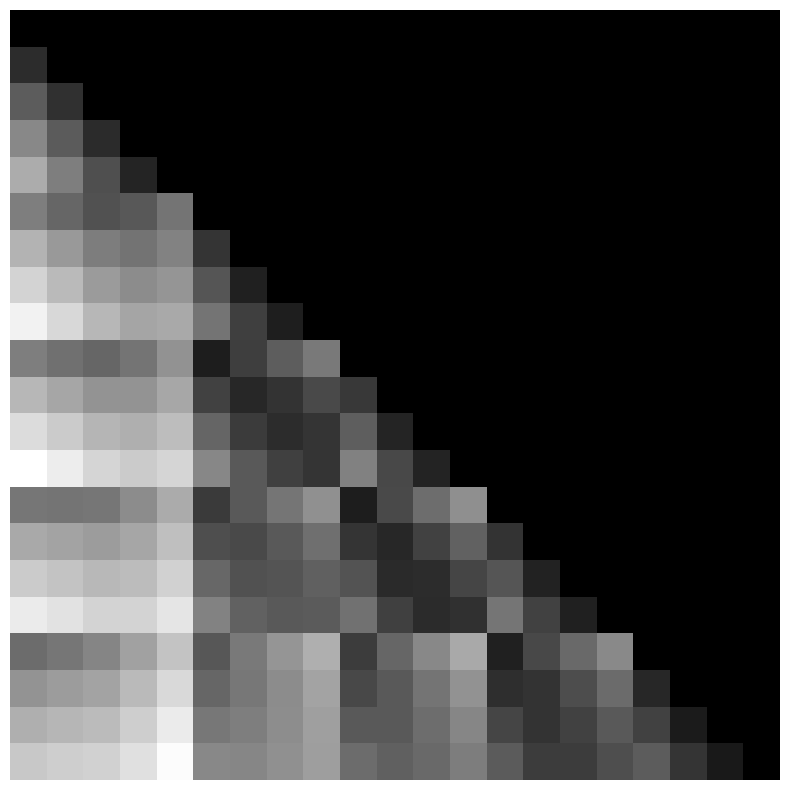

In [41]:
from scipy.spatial.distance import pdist, squareform

raw_0_path = '../data/raw/keypoint_0.csv'
coords_list = load_raw(raw_0_path)

row_1 = coords_list[0]
landmark_array = np.array(row_1)
distances = pdist(landmark_array, 'euclidean')
jcd_features = squareform(distances)[np.tril_indices(len(landmark_array), k=-1)]
# print(len(jcd_features))

n = int(np.ceil(np.sqrt(len(jcd_features) * 2)))
jcd_matrix = np.zeros((n, n))
jcd_matrix[np.tril_indices(n, k=-1)] = jcd_features

plt.figure(figsize=(10, 10))
plt.imshow(jcd_matrix, cmap='gray', interpolation='nearest')
plt.axis('off')
plt.savefig('jcd_matrix.png', bbox_inches='tight', pad_inches=0)
plt.show()

In [10]:
def merge_label_jcd(jcd_dir, save_path):
    all_jcd_data = []
    for jcd_file in glob.glob(os.path.join(jcd_dir, 'jcd_*.csv')):
        label = int(os.path.basename(jcd_file).split('_')[1].split('.')[0])
        df = pd.read_csv(jcd_file, header=None)
        df['label'] = label
        all_jcd_data.append(df)

    merged_df = pd.concat(all_jcd_data, ignore_index=True)
    merged_df = merged_df.sample(frac=1).reset_index(drop=True)
    merged_df.to_csv(save_path, index=False, header=False)
    print(f"Merged JCD data with labels saved to: {save_path}")


jcd_dir = '../data/jcd'
merge_path = '../data/merge_jcd.csv'
merge_label_jcd(jcd_dir, merge_path)

Merged JCD data with labels saved to: ../data/merge_jcd.csv


# Train

In [2]:
from tensorflow.keras.layers import Input, Dense, BatchNormalization, LeakyReLU, Dropout
from tensorflow.keras.models import Model


def build_dd_net(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    x = Dense(256, use_bias=False)(inputs)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.01)(x)
    x = Dropout(0.5)(x)

    x = Dense(128, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.01)(x)
    x = Dropout(0.5)(x)

    x = Dense(64, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.01)(x)
    x = Dropout(0.5)(x)

    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)

    return model

# # Example usage:
# input_shape = (231,)  # for example, 231 JCD features
# num_classes = 5  # assuming 5 classes for classification
#
# model = build_simplified_dd_net(input_shape, num_classes)
# model.summary()

2024-04-10 04:18:11.199567: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-10 04:18:11.240012: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-10 04:18:11.240732: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-10 04:18:13.300971: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping


def load_data(csv_file):
    df = pd.read_csv(csv_file, header=None)
    X = df.iloc[:, :-1].apply(pd.to_numeric).values
    y = df.iloc[:, -1].apply(pd.to_numeric).values
    return X, y


RANDOM_SEED = 42
dataset = '../data/merge_jcd.csv'
# model_save_path = '../models/ddnet_model.h5'
model_save_path = '../models/ddnet_model_pre.h5'

X, y = load_data('../data/merge_jcd.csv')
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.75, random_state=RANDOM_SEED)

input_shape = X_train.shape[1:]  # (210,)
num_classes = len(set(y_train))  # 5
cp_callback = ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
es_callback = EarlyStopping(patience=100, verbose=1)

model = build_dd_net(input_shape, num_classes)

2024-04-10 04:18:19.095216: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


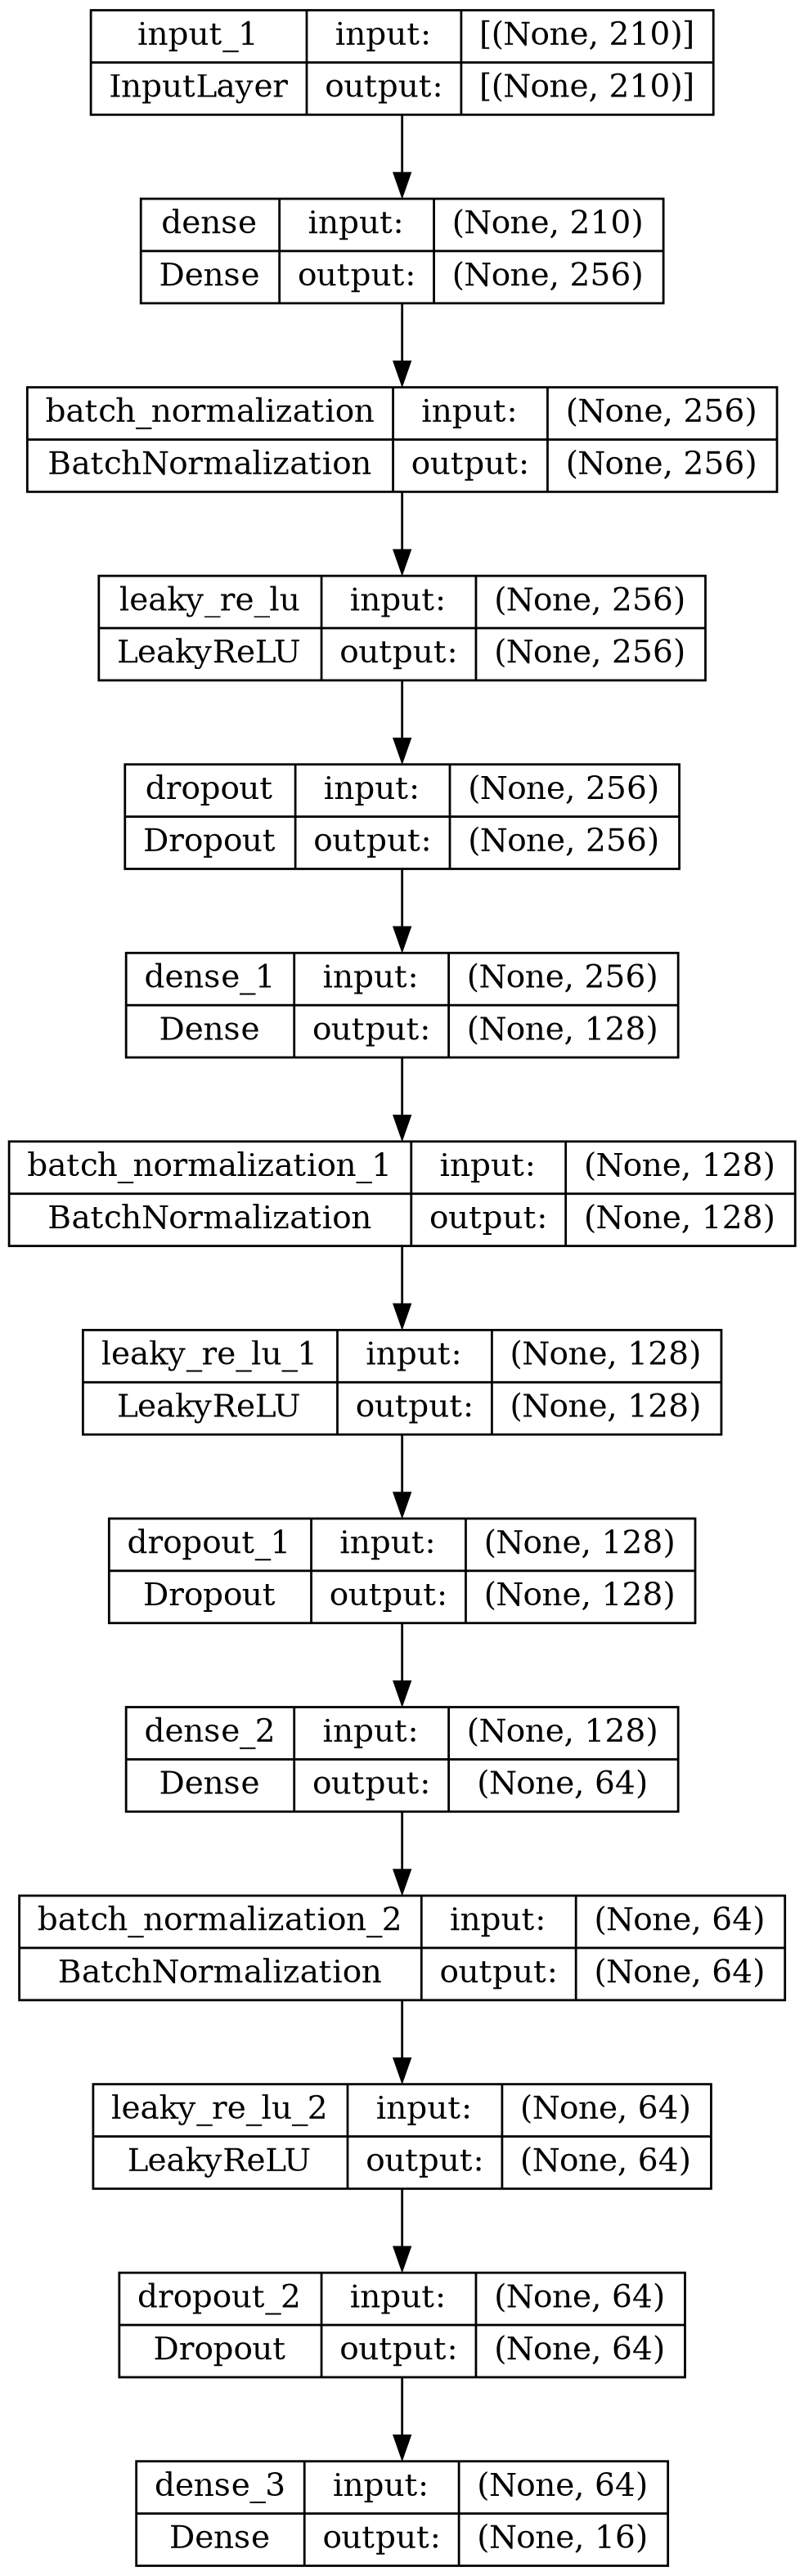

In [55]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='model_plot.png', show_shapes=True, dpi=200)

In [56]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 210)]             0         
                                                                 
 dense (Dense)               (None, 256)               53760     
                                                                 
 batch_normalization (Batch  (None, 256)               1024      
 Normalization)                                                  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 256)               0         
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32768     
                                                             

In [4]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=1000,
    batch_size=128,
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
1/1 [==============================] - ETA: 0s - loss: 3.7027 - accuracy: 0.0417
Epoch 1: saving model to ../models/ddnet_model_pre.h5
1/1 [==============================] - 2s 2s/step - loss: 3.7027 - accuracy: 0.0417 - val_loss: 18.9325 - val_accuracy: 0.0750
Epoch 2/1000
1/1 [==============================] - ETA: 0s - loss: 3.5050 - accuracy: 0.0833
Epoch 2: saving model to ../models/ddnet_model_pre.h5
1/1 [==============================] - 0s 63ms/step - loss: 3.5050 - accuracy: 0.0833 - val_loss: 10.6880 - val_accuracy: 0.0750
Epoch 3/1000
1/1 [==============================] - ETA: 0s - loss: 3.4862 - accuracy: 0.0417
Epoch 3: saving model to ../models/ddnet_model_pre.h5
1/1 [==============================] - 0s 62ms/step - loss: 3.4862 - accuracy: 0.0417 - val_loss: 7.4114 - val_accuracy: 0.0750
Epoch 4/1000
1/1 [==============================] - ETA: 0s - loss: 3.2677 - accuracy: 0.0917
Epoch 4: saving model to ../models/ddnet_model_pre.h5


/home/jonathan/PycharmProjects/DD-Net/venv/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 65ms/step - loss: 3.2677 - accuracy: 0.0917 - val_loss: 5.8390 - val_accuracy: 0.1250
Epoch 5/1000
1/1 [==============================] - ETA: 0s - loss: 3.3507 - accuracy: 0.0917
Epoch 5: saving model to ../models/ddnet_model_pre.h5
1/1 [==============================] - 0s 65ms/step - loss: 3.3507 - accuracy: 0.0917 - val_loss: 5.0201 - val_accuracy: 0.2500
Epoch 6/1000
1/1 [==============================] - ETA: 0s - loss: 3.0864 - accuracy: 0.1083
Epoch 6: saving model to ../models/ddnet_model_pre.h5
1/1 [==============================] - 0s 67ms/step - loss: 3.0864 - accuracy: 0.1083 - val_loss: 4.4847 - val_accuracy: 0.3250
Epoch 7/1000
1/1 [==============================] - ETA: 0s - loss: 3.0140 - accuracy: 0.2250
Epoch 7: saving model to ../models/ddnet_model_pre.h5
1/1 [==============================] - 0s 61ms/step - loss: 3.0140 - accuracy: 0.2250 - val_loss: 4.1634 - val_accuracy: 0.3250
Epoch 8/1000
1/1 [==========================

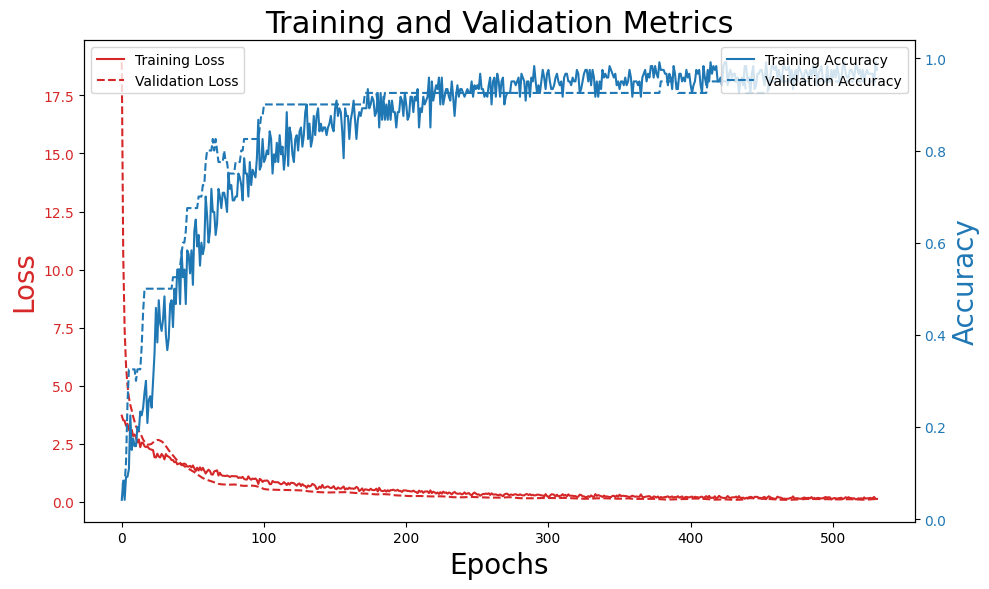

In [10]:
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:red'
ax1.set_xlabel('Epochs', fontsize=20)
ax1.set_ylabel('Loss', color=color, fontsize=20)
ax1.plot(history.history['loss'], label='Training Loss', color=color)
ax1.plot(history.history['val_loss'], label='Validation Loss', linestyle='--', color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend(loc='upper left')

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('Accuracy', color=color, fontsize=20)
ax2.plot(history.history['accuracy'], label='Training Accuracy', color=color)
ax2.plot(history.history['val_accuracy'], label='Validation Accuracy', linestyle='--', color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(loc='upper right')

plt.title('Training and Validation Metrics', fontsize=22)
fig.tight_layout()
plt.savefig('loss accuracy.png', dpi=300, bbox_inches='tight', pad_inches=0.05)
plt.show()


In [5]:
import tensorflow as tf
import numpy as np

class ClassAccuracyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        predictions = self.model.predict(X_val)
        predicted_classes = np.argmax(predictions, axis=1)
        for class_id in np.unique(y_val):
            true_labels = y_val == class_id
            predicted_labels = predicted_classes == class_id
            accuracy = np.mean(true_labels == predicted_labels)
            print(f'Accuracy for class {class_id}: {accuracy:.4f}')


class_accuracy_callback = ClassAccuracyCallback()

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=1000,
    batch_size=128,
    callbacks=[cp_callback, es_callback, class_accuracy_callback]
)


Epoch 1/1000
1/1 [==============================] - ETA: 0s - loss: 3.2562 - accuracy: 0.0833
Epoch 1: saving model to ../models/ddnet_model_pre.h5
2/2 [==============================] - 0s 2ms/step
Accuracy for class 0: 0.9250
Accuracy for class 1: 0.9500
Accuracy for class 2: 0.9250
Accuracy for class 3: 0.6750
Accuracy for class 5: 0.9500
Accuracy for class 6: 0.8750
Accuracy for class 7: 0.9250
Accuracy for class 8: 0.5000
Accuracy for class 9: 0.9250
Accuracy for class 10: 0.8500
Accuracy for class 11: 0.9250
Accuracy for class 12: 0.9250
Accuracy for class 13: 0.9000
Accuracy for class 14: 0.9750
Accuracy for class 15: 0.9750
1/1 [==============================] - 2s 2s/step - loss: 3.2562 - accuracy: 0.0833 - val_loss: 17.4842 - val_accuracy: 0.1000
Epoch 2/1000
1/1 [==============================] - ETA: 0s - loss: 3.3005 - accuracy: 0.0917

/home/jonathan/PycharmProjects/DD-Net/venv/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: saving model to ../models/ddnet_model_pre.h5
2/2 [==============================] - 0s 2ms/step
Accuracy for class 0: 0.9250
Accuracy for class 1: 0.9500
Accuracy for class 2: 0.9250
Accuracy for class 3: 0.6500
Accuracy for class 5: 0.9500
Accuracy for class 6: 0.8750
Accuracy for class 7: 0.9250
Accuracy for class 8: 0.5000
Accuracy for class 9: 0.9250
Accuracy for class 10: 0.8250
Accuracy for class 11: 0.9250
Accuracy for class 12: 0.9250
Accuracy for class 13: 0.9000
Accuracy for class 14: 0.9750
Accuracy for class 15: 0.9750
1/1 [==============================] - 0s 123ms/step - loss: 3.3005 - accuracy: 0.0917 - val_loss: 14.3213 - val_accuracy: 0.0750
Epoch 3/1000
1/1 [==============================] - ETA: 0s - loss: 3.3758 - accuracy: 0.0833
Epoch 3: saving model to ../models/ddnet_model_pre.h5
2/2 [==============================] - 0s 2ms/step
Accuracy for class 0: 0.9250
Accuracy for class 1: 0.9500
Accuracy for class 2: 0.9250
Accuracy for class 3: 0.6750
Accuracy